In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [69]:
import nest_asyncio
import uuid
import torch
from vllm import AsyncEngineArgs, AsyncLLMEngine, SamplingParams
from pprint import pprint
import json
import re

from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct

from langgraph.graph import StateGraph
from langsmith import traceable

from typing_extensions import TypedDict 

from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Annotated

from transformers import AutoTokenizer, AutoModel


# Ïù¥Î≤§Ìä∏ Î£®ÌîÑ Ï∂©Îèå Î∞©ÏßÄ
nest_asyncio.apply()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
model = AutoModel.from_pretrained("BAAI/bge-m3")
model.eval()

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 1024, padding_idx=1)
    (position_embeddings): Embedding(8194, 1024, padding_idx=1)
    (token_type_embeddings): Embedding(1, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-23): 24 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elem

In [5]:
gemma = "/home/mmm060400/KTB/models/google/gemma-3-4b-it/"

engine_args = AsyncEngineArgs(
    model=gemma,
    tensor_parallel_size=1,
    gpu_memory_utilization=0.95,
    max_num_seqs = 100,
    max_model_len=4096,
    max_num_batched_tokens=8192
)
llm = AsyncLLMEngine.from_engine_args(engine_args)

INFO 05-04 16:06:48 [config.py:600] This model supports multiple tasks: {'classify', 'score', 'embed', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 05-04 16:06:48 [config.py:1780] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 05-04 16:06:51 [core.py:61] Initializing a V1 LLM engine (v0.8.3) with config: model='/home/mmm060400/KTB/models/google/gemma-3-4b-it/', speculative_config=None, tokenizer='/home/mmm060400/KTB/models/google/gemma-3-4b-it/', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar', reasoning_backend=None), observability_config=Observability

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


INFO 05-04 16:07:00 [gpu_model_runner.py:1258] Starting to load model /home/mmm060400/KTB/models/google/gemma-3-4b-it/...
INFO 05-04 16:07:00 [config.py:3334] cudagraph sizes specified by model runner [1, 2, 4, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200, 208, 216, 224, 232, 240, 248, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336, 344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440, 448, 456, 464, 472, 480, 488, 496, 504, 512] is overridden by config [512, 384, 256, 128, 4, 2, 1, 392, 264, 136, 8, 400, 272, 144, 16, 408, 280, 152, 24, 416, 288, 160, 32, 424, 296, 168, 40, 432, 304, 176, 48, 440, 312, 184, 56, 448, 320, 192, 64, 456, 328, 200, 72, 464, 336, 208, 80, 472, 344, 216, 88, 120, 480, 352, 248, 224, 96, 488, 504, 360, 232, 104, 496, 368, 240, 112, 376]
WARNING 05-04 16:07:01 [topk_topp_sampler.py:69] FlashInfer is not available. Falling back to the PyTorch-native implementation of top-p & to

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 05-04 16:07:03 [loader.py:447] Loading weights took 2.46 seconds
INFO 05-04 16:07:03 [gpu_model_runner.py:1273] Model loading took 8.5833 GiB and 2.685266 seconds
INFO 05-04 16:07:03 [gpu_model_runner.py:1542] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 32 image items of the maximum feature size.
INFO 05-04 16:07:24 [backends.py:416] Using cache directory: /home/mmm060400/.cache/vllm/torch_compile_cache/90ec895879/rank_0_0 for vLLM's torch.compile
INFO 05-04 16:07:24 [backends.py:426] Dynamo bytecode transform time: 14.75 s
INFO 05-04 16:07:25 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 05-04 16:07:36 [monitor.py:33] torch.compile takes 14.75 s in total
INFO 05-04 16:07:38 [kv_cache_utils.py:578] GPU KV cache size: 57,792 tokens
INFO 05-04 16:07:38 [kv_cache_utils.py:581] Maximum concurrency for 4,096 tokens per request: 14.11x
INFO 05-04 16:08:08 [gpu_model_runner.py:1608] Graph capturing finished in 

In [6]:
sampling_params = SamplingParams(temperature=0.6, top_p=0.7, repetition_penalty=1.1, max_tokens=4096, stop = ["<eos>"])


# ÎπÑÎèôÍ∏∞ LLM Ïã§Ìñâ (non-streaming)
async def llm_engine(prompt: str) -> str:
    request_id = str(uuid.uuid4())
    last_output = None

    async for output in llm.generate(
        prompt=prompt,
        sampling_params=sampling_params,
        request_id=request_id
    ):
        last_output = output.outputs[0].text  # ‚úÖ ÎçÆÏñ¥Ïì∞Í∏∞Îßå Ìï®

    return last_output if last_output is not None else ""



async def llm_til(prompt: str) -> str:
    try:
        result = await llm_engine(prompt)
        return result
    except Exception as e:
        print(f"‚ùå LLM Ìò∏Ï∂ú Ïã§Ìå®: {e}")
        return "[LLM Ìò∏Ï∂ú Ïã§Ìå®]"

In [7]:
# JSON ÌååÏùº ÏùΩÍ∏∞
with open("/home/mmm060400/KTB/Data/response_dia.json", 'r', encoding='utf-8') as file:
    data = json.load(file)
data

{'username': 'ConconDev',
 'date': '2024-09-06',
 'repo': 'backend',
 'files': [{'filepath': 'src/main/java/com/sookmyung/concon/Alarm/controller/AlarmController.java',
   'latest_code': 'import com.sookmyung.concon.Alarm.service.AlarmService;\nimport lombok.RequiredArgsConstructor;\nimport org.springframework.http.MediaType;\nimport org.springframework.http.ResponseEntity;\nimport org.springframework.web.bind.annotation.GetMapping;\nimport org.springframework.web.bind.annotation.RequestHeader;\nimport org.springframework.web.bind.annotation.RestController;\nimport org.springframework.web.servlet.mvc.method.annotation.SseEmitter;\n\n@RestController("/api/alarm")\n@RequiredArgsConstructor\npublic class AlarmController {\n    private final AlarmService alarmService;\n\n    @GetMapping(value = "/subscribe", produces = MediaType.TEXT_EVENT_STREAM_VALUE)\n    public ResponseEntity<SseEmitter> subscribe(\n            @RequestHeader("Authorization") String token) {\n        return ResponseEnt

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Dict, Optional, Annotated
from functools import reduce

In [114]:
def merge_dicts(x: dict, y: dict) -> dict:
    if x is None:
        return y
    if y is None:
        return x
    return {**x, **y}


class PatchModel(BaseModel):
    commit_message: str
    patch: str


class FileModel(BaseModel):
    filepath: str
    latest_code: str
    patches: List[PatchModel]


class TilJsonModel(BaseModel):
    username: str
    date: str
    repo: str
    title: str
    keywords: List[str]
    content: str
    vector: List[float]


class StateModel(BaseModel):
    username: str
    date: str
    repo: str
    files: List[Dict]  # node_idÍ∞Ä Ìè¨Ìï®Îêú ÌååÏùº Î¶¨Ïä§Ìä∏

    # ÏÑ†ÌÉù ÌïÑÎìúÎì§ (Ï¥àÍ∏∞Ïóî ÏóÜÏùÑ Ïàò ÏûàÏùå)
    code_summary: Annotated[Dict[str, str], merge_dicts] = Field(default_factory=dict)
    patch_summary: Annotated[Dict[str, str], merge_dicts] = Field(default_factory=dict)
    til_draft: Optional[str] = None
    til_final: Optional[str] = None
    til_json: Optional[TilJsonModel] = None

In [115]:
@traceable
def fork_code_nodes(state: dict):
    # print(state)
    
    files = state.files
    
    # files Î¶¨Ïä§Ìä∏Î•º ÏÉàÎ°úÏö¥ ÌòïÌÉúÎ°ú ÏóÖÎç∞Ïù¥Ìä∏
    updated_files = [
        {
            "file": file,    # file ÌïòÎÇò
            "node_id": i + 1  # node Î≤àÌò∏ Î∂ÄÏó¨
        }
        for i, file in enumerate(files)
    ]
    
    state_dict = state.model_dump()
    state_dict["files"] = updated_files
    return StateModel(**state_dict)

## ÌîÑÎ°¨ÌîÑÌä∏ Ìï®Ïàò(Legacy)

In [116]:
# # code summary Ìï®Ïàò
# def make_code_summary_prompt(file: dict) -> str:
#     filepath = file["filepath"]
#     latest_code = file["latest_code"]

#     prompt = f"""
# Îã§ÏùåÏùÄ ÏÜåÌîÑÌä∏Ïõ®Ïñ¥ ÌîÑÎ°úÏ†ùÌä∏Ïùò ÌïòÎÇòÏùò ÏÜåÏä§ÏΩîÎìú ÌååÏùºÏûÖÎãàÎã§.
# Ïù¥ ÏΩîÎìúÎäî Ïñ¥Îñ§ Ïó≠Ìï†ÏùÑ ÏàòÌñâÌïòÎ©∞, Ïñ¥Îñ§ Í∏∞Îä•Ïù¥ÎÇò Ï±ÖÏûÑÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÎäîÏßÄ ÏöîÏïΩÌï¥ Ï£ºÏÑ∏Ïöî.

# ÌååÏùº Ï†ÑÏ≤¥Î•º Í∏∞Î∞òÏúºÎ°ú ÏïÑÎûò Ìï≠Î™©ÏùÑ Ï§ëÏã¨ÏúºÎ°ú Î∂ÑÏÑùÌï¥Ï£ºÏÑ∏Ïöî:
# 1. Ïù¥ ÌååÏùºÏùÄ Ïñ¥Îñ§ Í∏∞Ïà† Ïä§ÌÉù(ÌîÑÎ†àÏûÑÏõåÌÅ¨, Ïñ∏Ïñ¥ Îì±)ÏùÑ ÏÇ¨Ïö©ÌïòÎÇòÏöî?
# 2. Ïù¥ ÏΩîÎìúÏùò Ï£ºÏöî Í∏∞Îä• ÎòêÎäî Î™©Ï†ÅÏùÄ Î¨¥ÏóáÏù∏Í∞ÄÏöî?
# 3. Ïù¥ ÏΩîÎìúÍ∞Ä ÌîÑÎ°úÏ†ùÌä∏ Ï†ÑÏ≤¥ÏóêÏÑú Ïñ¥Îñ§ Ï±ÖÏûÑÏùÑ Îß°Í≥† ÏûàÎäîÏßÄ Ï∂îÎ°†Ìï¥ Ï£ºÏÑ∏Ïöî.

# ÌååÏùº Í≤ΩÎ°ú:
# {filepath}

# ÏΩîÎìú:
# {latest_code}
# """
#     return prompt

# # patch summary Ìï®Ïàò
# def make_patch_summary_prompt(code_summary: str, patch_section: str) -> str:
#     prompt = f"""
# Îã§ÏùåÏùÄ ÏÜåÌîÑÌä∏Ïõ®Ïñ¥ ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑú ÏûëÏÑ±Îêú ÌïòÎÇòÏùò ÏÜåÏä§ÏΩîÎìú ÌååÏùºÏóê ÎåÄÌïú Î∂ÑÏÑù Í≤∞Í≥ºÏûÖÎãàÎã§:

# [ÏΩîÎìú ÏöîÏïΩ]
# {code_summary}

# Ïù¥ ÏΩîÎìúÎäî Îã§ÏùåÍ≥º Í∞ôÏùÄ Î≥ÄÍ≤Ω ÏÇ¨Ìï≠(patch)Îì§ÏùÑ Í±∞Ï≥ê ÏµúÏ¢Ö ÌòïÌÉúÎ°ú ÏôÑÏÑ±ÎêòÏóàÏäµÎãàÎã§.  
# Í∞Å Î≥ÄÍ≤Ω ÏÇ¨Ìï≠Ïù¥ Í∏∞Ï°¥ ÏΩîÎìú Íµ¨Ï°∞Ïóê Ïñ¥Îñ§ Í∏∞Îä•ÏùÑ Ï∂îÍ∞ÄÌïòÍ±∞ÎÇò Î¨∏Ï†úÎ•º Ìï¥Í≤∞ÌñàÎäîÏßÄ Î∂ÑÏÑùÌï¥Ï£ºÏÑ∏Ïöî.  
# ÎòêÌïú Ï†ÑÏ≤¥Ï†ÅÏù∏ Î≥ÄÍ≤Ω ÌùêÎ¶ÑÏóêÏÑú Ïñ¥Îñ§ ÏàúÏ∞®Ï†Å ÏùòÎØ∏ÎÇò Ìå®ÌÑ¥Ïù¥ ÏûàÎäîÏßÄÎèÑ Ìï®Íªò ÏÑ§Î™ÖÌï¥Ï£ºÏÑ∏Ïöî.
# ÏΩîÎìú ÏûêÏ≤¥Ïùò ÌäπÏßïÎßå Î∂ÑÏÑùÌï¥Ï£ºÏÑ∏Ïöî. Ï∂îÍ∞Ä Í∞úÏÑ†Ï†êÏùÄ ÌïÑÏöî ÏóÜÏäµÎãàÎã§.

# [Î≥ÄÍ≤Ω Ïù¥Î†• Î™©Î°ù]
# {patch_section}

# ÏöîÏïΩ Ìè¨Îß∑ ÏòàÏãú:
# 1. Í∞Å patchÍ∞Ä Í∏∞Ï°¥ Íµ¨Ï°∞Ïóê Ïñ¥Îñ§ ÏòÅÌñ•ÏùÑ Ï£ºÏóàÎäîÏßÄ
# 2. Ïñ¥Îñ§ Í∏∞Îä•Ïù¥ Ï∂îÍ∞ÄÎêòÏóàÏúºÎ©∞, Ïôú ÌïÑÏöîÌïú Î≥ÄÍ≤ΩÏù¥ÏóàÎäîÏßÄ
# 3. Î≥ÄÍ≤ΩÏùò ÌùêÎ¶Ñ ÏÉÅ Ïñ¥Îñ§ ÏàúÏÑúÎ•º Í∞ñÎäîÏßÄ
# 4. Ïù¥Îü¨Ìïú Î≥ÄÍ≤ΩÏùò Î™©Ï†ÅÏù¥ Î¨¥ÏóáÏù¥ÏóàÎäîÏßÄ
# 5. ÏΩîÎìú Î≥ÄÍ≤ΩÏúºÎ°ú Ïù∏Ìï¥ ÏñªÏùÑ Ïàò ÏûàÎäî Ìö®Í≥º

# ÎãµÎ≥ÄÏùÄ Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú ÌïúÍµ≠Ïñ¥Î°ú ÏûëÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî. ÏΩîÎìú Î∂ÑÏÑù ÎÇ¥Ïö©Ïóê ÎåÄÌï¥ÏÑúÎäî ÏûëÏÑ±ÌïòÏßÄ ÏïäÏïÑÎèÑ Îê©ÎãàÎã§.
# """
#     return prompt

# # TIL Ï¥àÏïà ÏÉùÏÑ± ÌîÑÎ°¨ÌîÑÌä∏
# def make_til_draft_prompt(username: str, date: str, repo: str, combined_summary: str) -> str:
#     prompt = f"""
# Îã§ÏùåÏùÄ ÌïòÎÇò Ïù¥ÏÉÅÏùò ÏÜåÏä§ÏΩîÎìú ÌååÏùºÏóê ÎåÄÌïú Î∂ÑÏÑù ÏöîÏïΩÍ≥º Î≥ÄÍ≤Ω Ïù¥Î†• Î∂ÑÏÑùÏûÖÎãàÎã§. Ïù¥Î•º Ï∞∏Í≥†ÌïòÏó¨ ÎßàÌÅ¨Îã§Ïö¥ ÌòïÏãùÏùò TILÏùÑ ÏûëÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî.

# [ÏΩîÎìú + Î≥ÄÍ≤Ω ÏöîÏïΩ]
# {combined_summary}

# ÏöîÍµ¨ Ï°∞Í±¥:
# - Îã§Ïùå ÌòïÏãùÏùò JSONÏúºÎ°ú ÏûëÏÑ±:
# {{
#   "user": "{username}",
#   "date": "{date}",
#   "repo": "{repo}",
#   "title": "<{date} Ìè¨Ìï® Ï†úÎ™©>",
#   "keywords": ["<ÌïµÏã¨ Í∏∞Ïà† ÌÇ§ÏõåÎìú 1~3Í∞ú>"],
#   "content": "<ÎßàÌÅ¨Îã§Ïö¥ ÌòïÏãù TIL>"
# }}

# TIL ÏûëÏÑ± Ïãú Î∞òÎìúÏãú Ìè¨Ìï®Ìï† Ìï≠Î™© (Í∞úÏ°∞Ïãù):
# 1. Ïò§Îäò Î∞∞Ïö¥ ÎÇ¥Ïö©
# 2. Í∞úÎÖê Ï†ïÎ¶¨
# 3. Ìï¥Îãπ Í∞úÎÖêÏù¥ ÌïÑÏöîÌïú Ïù¥Ïú†
# 4. Í∞úÎÖêÏùÑ ÌôúÏö©ÌïòÎäî Î∞©Î≤ï
# 5. Î¨∏Ï†ú Ìï¥Í≤∞ Í≥ºÏ†ï
# 6. ÌïòÎ£® ÌöåÍ≥†
# 7. Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Í∞úÏ°∞Ïãù Î¨∏Ïû• Íµ¨ÏÑ±

# TIL ÎÇ¥Ïö©ÏùÄ ÌïúÍµ≠Ïñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî.
# """
#     return prompt

In [117]:
# code summary Ìï®Ïàò
def make_code_summary_prompt(file: dict) -> str:
    filepath = file["filepath"]
    latest_code = file["latest_code"]

    prompt = f"""
Îã§ÏùåÏùÄ ÏÜåÌîÑÌä∏Ïõ®Ïñ¥ ÌîÑÎ°úÏ†ùÌä∏Ïùò ÌïòÎÇòÏùò ÏÜåÏä§ÏΩîÎìú ÌååÏùºÏûÖÎãàÎã§.
Ï£ºÏñ¥ÏßÑ ÏΩîÎìúÎ•º Î∂ÑÏÑùÌïòÏó¨ ÌïµÏã¨ ÎÇ¥Ïö©ÏùÑ Í∞ÑÎã®Ìïú Í∞úÏ°∞Ïãù Î¨∏Ïû•ÏúºÎ°ú ÏöîÏïΩÌï¥ Ï£ºÏÑ∏Ïöî.

ÏöîÏïΩ Ìï≠Î™©:
- ÏÇ¨Ïö© Í∏∞Ïà† Ïä§ÌÉù (Ïñ∏Ïñ¥, ÌîÑÎ†àÏûÑÏõåÌÅ¨)
- Ï£ºÏöî Í∏∞Îä•
- ÌîÑÎ°úÏ†ùÌä∏ ÎÇ¥ Í∏∞Îä•

ÏöîÏïΩÏùÄ Îã§ÏùåÏ≤òÎüº Í∞úÏ°∞ÏãùÏúºÎ°ú ÏûëÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî:

ÏòàÏãú:
- Ïñ∏Ïñ¥: Python, ÌîÑÎ†àÏûÑÏõåÌÅ¨: FastAPI
- Í∏∞Îä•: ÏÇ¨Ïö©Ïûê Ïù∏Ï¶ù Ï≤òÎ¶¨
- Í∏∞Îä•: API ÏÑúÎ≤Ñ Ïù∏Ï¶ù Î™®Îìà Îã¥Îãπ

[ÌååÏùº Í≤ΩÎ°ú]
{filepath}

[ÏΩîÎìú]
{latest_code}
"""
    return prompt

# patch summary Ìï®Ïàò
def make_patch_summary_prompt(code_summary: str, patch_section: str) -> str:
    prompt = f"""
Îã§ÏùåÏùÄ ÌïòÎÇòÏùò ÏÜåÏä§ÏΩîÎìú ÌååÏùºÏóê ÎåÄÌïú ÏΩîÎìú ÏöîÏïΩÍ≥º Î≥ÄÍ≤Ω Ïù¥Î†•ÏûÖÎãàÎã§.
Î≥ÄÍ≤Ω Ïù¥Î†•(patch)ÏùÑ Î∞îÌÉïÏúºÎ°ú Î≥ÄÍ≤Ω Î™©Ï†ÅÍ≥º Ï£ºÏöî ÏàòÏ†ïÏÇ¨Ìï≠ÏùÑ Í∞ÑÎã®Ìïú Í∞úÏ°∞Ïãù Î¨∏Ïû•ÏúºÎ°ú ÏöîÏïΩÌï¥ Ï£ºÏÑ∏Ïöî.

[ÏΩîÎìú ÏöîÏïΩ]
{code_summary}

[Î≥ÄÍ≤Ω Ïù¥Î†•]
{patch_section}

ÏöîÏïΩ Ìï≠Î™©:
- Ï£ºÏöî Î≥ÄÍ≤Ω Î™©Ï†Å
- ÌïµÏã¨ ÏàòÏ†ïÏÇ¨Ìï≠ ÏöîÏïΩ
- Î≥ÄÍ≤Ω ÌùêÎ¶Ñ ÏöîÏïΩ (ÌïÑÏöî Ïãú)

ÏöîÏïΩÏùÄ Îã§ÏùåÏ≤òÎüº Í∞úÏ°∞ÏãùÏúºÎ°ú ÏûëÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî:

ÏòàÏãú:
- Í∏∞Îä• Ï∂îÍ∞Ä: OAuth Ïù∏Ï¶ù Î™®Îìà ÎèÑÏûÖ
- Î≤ÑÍ∑∏ ÏàòÏ†ï: Î°úÍ∑∏Ïù∏ ÏÑ∏ÏÖò ÎßåÎ£å Î¨∏Ï†ú Ìï¥Í≤∞
- Íµ¨Ï°∞ Í∞úÏÑ†: Controller Î†àÏù¥Ïñ¥ Î∂ÑÎ¶¨

ÎãµÎ≥ÄÏùÄ ÌïúÍµ≠Ïñ¥Î°ú, Í∞úÏ°∞Ïãù Î¨∏Ïû•ÏúºÎ°úÎßå ÏûëÏÑ±ÌïòÏÑ∏Ïöî.
"""
    return prompt


# TIL Ï¥àÏïà ÏÉùÏÑ± ÌîÑÎ°¨ÌîÑÌä∏

# TIL Ï¥àÏïà ÏÉùÏÑ± ÌîÑÎ°¨ÌîÑÌä∏
def til_draft_prompt(username: str, date: str, repo: str, combined_summary: str) -> str:
    prompt = f"""
Îã§ÏùåÏùÄ ÌïòÎÇò Ïù¥ÏÉÅÏùò ÏÜåÏä§ÏΩîÎìú ÌååÏùºÏóê ÎåÄÌïú Î∂ÑÏÑù ÏöîÏïΩÍ≥º Î≥ÄÍ≤Ω Ïù¥Î†• Î∂ÑÏÑùÏûÖÎãàÎã§. Ïù¥Î•º Ï∞∏Í≥†ÌïòÏó¨ ÎßàÌÅ¨Îã§Ïö¥ ÌòïÏãùÏùò TILÏùÑ ÏûëÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî.

[ÏΩîÎìú + Î≥ÄÍ≤Ω ÏöîÏïΩ]
{combined_summary}

ÏöîÍµ¨ Ï°∞Í±¥:
- Îã§Ïùå ÌòïÏãùÏùò JSONÏúºÎ°ú ÏûëÏÑ±:
{{
  "user": "{username}",
  "date": "{date}",
  "repo": "{repo}",
  "title": "<{date} Ìè¨Ìï® Ï†úÎ™©>",
  "keywords": ["<ÌïµÏã¨ Í∏∞Ïà† ÌÇ§ÏõåÎìú 1~3Í∞ú>"],
  "content": "<ÎßàÌÅ¨Îã§Ïö¥ ÌòïÏãù TIL>"
}}

TIL ÏûëÏÑ± Ïãú Î∞òÎìúÏãú Ìè¨Ìï®Ìï† Ìï≠Î™© (Í∞úÏ°∞Ïãù):
1. Ïò§Îäò Î∞∞Ïö¥ ÎÇ¥Ïö©
2. Í∞úÎÖê Ï†ïÎ¶¨
3. Ìï¥Îãπ Í∞úÎÖêÏù¥ ÌïÑÏöîÌïú Ïù¥Ïú†
4. Í∞úÎÖêÏùÑ ÌôúÏö©ÌïòÎäî Î∞©Î≤ï
5. Î¨∏Ï†ú Ìï¥Í≤∞ Í≥ºÏ†ï
6. ÌïòÎ£® ÌöåÍ≥†
7. Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú Í∞úÏ°∞Ïãù Î¨∏Ïû• Íµ¨ÏÑ±

TIL ÎÇ¥Ïö©ÏùÄ ÌïúÍµ≠Ïñ¥Î°ú ÏûëÏÑ±ÌïòÏÑ∏Ïöî.
"""
    return prompt

# ÌîºÎìúÎ∞± Î£®ÌîÑ
def til_feedback_prompt(content: str) -> str:
    """
    TIL Ï¥àÏïàÏùÑ Î∞õÏïÑÏÑú Í∞úÏÑ† ÏßÄÏπ®ÏùÑ Ìè¨Ìï®Ìïú feedback promptÎ•º ÏÉùÏÑ±Ìï©ÎãàÎã§.

    Args:
        content (str): Ï¥àÏïà TIL ÎÇ¥Ïö© (ÎßàÌÅ¨Îã§Ïö¥ ÌÖçÏä§Ìä∏)

    Returns:
        str: LLMÏóêÍ≤å Ï†ÑÎã¨Ìï† ÏµúÏ¢Ö ÌîÑÎ°¨ÌîÑÌä∏ ÌÖçÏä§Ìä∏
    """
    feedback_prompt = f"""
Îã§ÏùåÏùÄ Ïò§Îäò ÌïôÏäµÌïú ÎÇ¥Ïö©ÏùÑ Ï†ïÎ¶¨Ìïú TIL Ï¥àÏïàÏûÖÎãàÎã§.

[TIL Ï¥àÏïà]
{content}

Ïù¥ TILÏùÑ Îã§Ïùå Í∏∞Ï§ÄÏóê Îî∞Îùº ÌèâÍ∞ÄÌïòÍ≥†, Îçî Íµ¨Ï≤¥Ï†ÅÏù¥Í≥† ÏùºÍ¥ÄÏÑ± ÏûàÎäî TILÎ°ú Í∞úÏÑ†Ìï¥ Ï£ºÏÑ∏Ïöî:

‚úÖ Í∞úÏÑ† Í∏∞Ï§Ä:
1. **Ï§ëÎ≥µ Î¨∏Ïû• Ï†úÍ±∞** ‚Äì Ïú†ÏÇ¨ÌïòÍ±∞ÎÇò Î∞òÎ≥µÎêòÎäî Î¨∏Ïû•ÏùÄ ÌïòÎÇòÎ°ú Ìï©Ï≥ê Ï£ºÏÑ∏Ïöî.
2. **ÌëúÌòÑÏùò Î™ÖÌôïÏÑ±** ‚Äì Î∂àÎ∂ÑÎ™ÖÌïòÍ±∞ÎÇò Î™®Ìò∏Ìïú ÌëúÌòÑÏùÑ Íµ¨Ï≤¥Ï†ÅÏúºÎ°ú Î∞îÍøî Ï£ºÏÑ∏Ïöî.
3. **Í∞úÏ°∞Ïãù ÌÜµÏùº** ‚Äì Î¨∏Ïû•Ìòï ÏÑúÏà†Ïù¥ ÏûàÎã§Î©¥ Í∞úÏ°∞ÏãùÏúºÎ°ú Ï†ïÎ¶¨Ìï¥ Ï£ºÏÑ∏Ïöî.
4. **Î∂àÌïÑÏöîÌïú ÏÑúÎ°† Ï†úÍ±∞** ‚Äì ÏßÄÎÇòÏπòÍ≤å ÏùºÎ∞òÏ†ÅÏù¥Í±∞ÎÇò Î∞òÎ≥µÎêòÎäî ÎÇ¥Ïö©ÏùÄ ÏÉùÎûµÌï¥ Ï£ºÏÑ∏Ïöî.
5. **ÏûêÏ£º ÏÇ¨Ïö©ÎêòÎäî Ï∂îÏÉÅ ÌëúÌòÑ Ï†úÍ±∞** ‚Äì "ÏÉàÎ°úÏö¥ Î©¥Î™®", "Ïã§Í∞êÎÇòÍ≤å", "Íæ∏Ï§ÄÌûà", "Ìù•ÎØ∏Î°úÏõ†Îã§" Îì±Ïùò Î™®Ìò∏Ìïú Í∞êÏ†ï/ÏÉÅÌÉú ÌëúÌòÑÏùÄ Íµ¨Ï≤¥Ï†ÅÏù∏ ÌñâÎèô, ÏÑ±Í≥º, Í≥ÑÌöçÏúºÎ°ú Î∞îÍøî Ï£ºÏÑ∏Ïöî.
6. **ÏûêÏó∞Ïä§Îü¨Ïö¥ Î¨∏Ïû• Íµ¨ÏÑ±** ‚Äì ÌïúÍµ≠Ïñ¥ ÎßûÏ∂§Î≤ï Î∞è Ïñ¥Ìà¨Î•º ÏûêÏó∞Ïä§ÎüΩÍ≤å Îã§Îì¨Ïñ¥ Ï£ºÏÑ∏Ïöî. Î¨∏Ïû•Ïù¥ ÎÑàÎ¨¥ Í∏∏Ïñ¥ÏßÄÎ©¥ Ï§ÑÎ∞îÍøàÏúºÎ°ú Íµ¨Ï°∞Î•º ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú Î≥¥Ïù¥Í≤å ÏûëÏÑ±ÌïòÏÑ∏Ïöî.

‚úÖ Ï∂úÎ†• ÌòïÏãù:
- ÏàòÏ†ïÎêú TIL Ï†ÑÏ≤¥ (ÎßàÌÅ¨Îã§Ïö¥ ÌòïÏãù Ïú†ÏßÄ)

**Ï£ºÏùò**: Í≤∞Í≥ºÎäî Î∞òÎìúÏãú ÌïúÍµ≠Ïñ¥Î°ú ÏûëÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî. Ï¥àÏïàÏóê ÎåÄÌïú ÌîºÎìúÎ∞± Î∂ÄÎ∂ÑÏùÄ ÏûëÏÑ±ÌïòÏßÄ ÎßàÏÑ∏Ïöî. **TIL Î≥∏Î¨∏Îßå ÌïÑÏöîÌï©ÎãàÎã§.**
"""
    return feedback_prompt


In [118]:
def make_code_summary_node(node_id: int):
    @traceable(run_type="llm")
    async def code_summary_node(state: dict):
        files = state.files
        file_entry = next(file for file in files if file["node_id"] == node_id)
        file = file_entry["file"]

        prompt = make_code_summary_prompt(file)
        summary = await llm_til(prompt)

        return {"code_summary": {f"code_summary_{node_id}": summary}}
    return code_summary_node


In [119]:
def make_patch_summary_node(node_id: int):
    @traceable(run_type="llm")
    async def patch_summary_node(state: dict):
        files = state.files

        file_entry = next(file for file in files if file["node_id"] == node_id)
        file = file_entry["file"]

        code_summaries = state.code_summary
        code_summary = code_summaries.get(f"code_summary_{node_id}", "")

        patches = file.get("patches", [])
        if not patches:
            return {"patch_summary": {f"patch_summary_{node_id}": f"{code_summary}\n\n(Î≥ÄÍ≤Ω Ïù¥Î†• ÏóÜÏùå)"}}
        
        patch_section = "\n\n".join(
            f"{j+1}. Commit Message: {p['commit_message']}\nPatch:\n{p['patch']}"
            for j, p in enumerate(patches)
        )

        prompt = make_patch_summary_prompt(code_summary, patch_section)
        summary = await llm_til(prompt)

        return {"patch_summary": {f"patch_summary_{node_id}": summary}}
    return patch_summary_node


In [120]:
def clean_code_block(text: str) -> str:
    # ```json ~ ``` Î∏îÎ°ù Ï†úÍ±∞
    cleaned = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.DOTALL)
    return cleaned

In [121]:
# format_instructionsÎ•º partialÎ°ú Ï£ºÏûÖ
# prompt_template = prompt_template.partial(format_instructions=parser.get_format_instructions())

# ‚úÖ 4. til_draft_node
@traceable
async def til_draft_node(state: dict):
    username = state.username
    date = state.date
    repo = state.repo

    patch_summaries = state.patch_summary
    summaries = list(patch_summaries.values())
    combined_summary = "\n\n".join(summaries)

    prompt = til_draft_prompt(username, date, repo, combined_summary)

    draft_json_str = await llm_til(prompt)
    return {"til_draft": draft_json_str}

In [122]:
@traceable
def parse_til_to_json(state: dict) -> dict:
    til_draft = state.til_draft
    try:
        start = til_draft.find("```json")
        end = til_draft.find("```", start + 1)
        json_str = til_draft[start + 7:end].strip()
        parsed = json.loads(json_str)
        return {"til_json": parsed}
    except Exception as e:
        return {"til_json": {"error": f"JSON ÌååÏã± Ïã§Ìå®: {str(e)}"}}

In [134]:
# qdrant-server Ïù∏Ïä§ÌÑ¥Ïä§ IP ÏûÖÎ†•
client = QdrantClient(host="34.46.221.240", port=6333)

@traceable
def embed_and_store_in_qdrant_node(state: dict) -> dict:
    til_json = state.til_json
    if not til_json:
        raise ValueError("til_json is missing from state")

    # üîπ ÌÖçÏä§Ìä∏ ÏûÑÎ≤†Îî©: title + content
    title = til_json.title
    content = til_json.content
    text = f"query: {title}\n{content}"

    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True)

    with torch.no_grad():
        output = model(**encoded_input)

    embedding = output.last_hidden_state.mean(dim=1)[0].tolist()

    # üîπ payload Íµ¨ÏÑ± (vectorÎäî ÎπºÍ≥†)
    payload = {k: v for k, v in til_json.model_dump().items() if k != "vector"}

    # üîπ Qdrant Ìè¨Ïù∏Ìä∏ ÏÉùÏÑ± Î∞è Ï†ÄÏû•
    point = PointStruct(
        id=str(uuid.uuid4()),
        vector=embedding,
        payload=payload
    )

    client.upsert(collection_name="til_logs", points=[point])

    # ÏÉÅÌÉúÎäî Í∑∏ÎåÄÎ°ú Î∞òÌôò (Î≤°ÌÑ∞Îäî Ï†ÄÏû•ÏóêÎßå ÏÇ¨Ïö©)
    return state.til_json


In [135]:
# @traceable
# async def til_feedback_node(state: dict):
#     til_draft = state["til_draft"]
#     prompt = til_feedback_prompt(til_draft)
#     print(prompt)
#     til_final = await llm_til(prompt)
#     print("üî• [til_feedback_node] LLM Ï∂úÎ†•:", til_final)

#     return {"til_final": til_final}

In [136]:
s2 = StateModel(**data)
builder = StateGraph(StateModel)
builder.set_entry_point("fork")
builder.add_node("fork", fork_code_nodes)

# 1. ÏΩîÎìú ÏöîÏïΩ ÎÖ∏Îìú + Ìå®Ïπò ÏöîÏïΩ ÎÖ∏Îìú Ï∂îÍ∞Ä
for i in range(5):
    code_node_fn = make_code_summary_node(i+1)
    patch_node_fn = make_patch_summary_node(i+1)

    builder.add_node(f"code_summary_node{i+1}", code_node_fn)
    builder.add_node(f"patch_summary_node{i+1}", patch_node_fn)

    builder.add_edge("fork", f"code_summary_node{i+1}")  # fork ‚Üí code
    builder.add_edge(f"code_summary_node{i+1}", f"patch_summary_node{i+1}")  # code ‚Üí patch

# 2. TIL draft ÎÖ∏Îìú Ï∂îÍ∞Ä
builder.add_node("til_draft_node", til_draft_node)

# 3. Î™®Îì† patch_summary_node ‚Üí til_draft_node Ïó∞Í≤∞
for i in range(5):
    builder.add_edge(f"patch_summary_node{i+1}", "til_draft_node")

# builder.add_node("til_feedback_node", til_feedback_node)
# builder.add_edge("til_draft_node", "til_feedback_node")
builder.add_node("json_parse_node", parse_til_to_json)
builder.add_edge("til_draft_node", "json_parse_node")

builder.add_node("embedding_til_node", embed_and_store_in_qdrant_node)
builder.add_edge("json_parse_node", "embedding_til_node")
builder.set_finish_point("embedding_til_node")
# builder.set_finish_point("json_parse_node")

# 4. Ïª¥ÌååÏùº
graph = builder.compile()

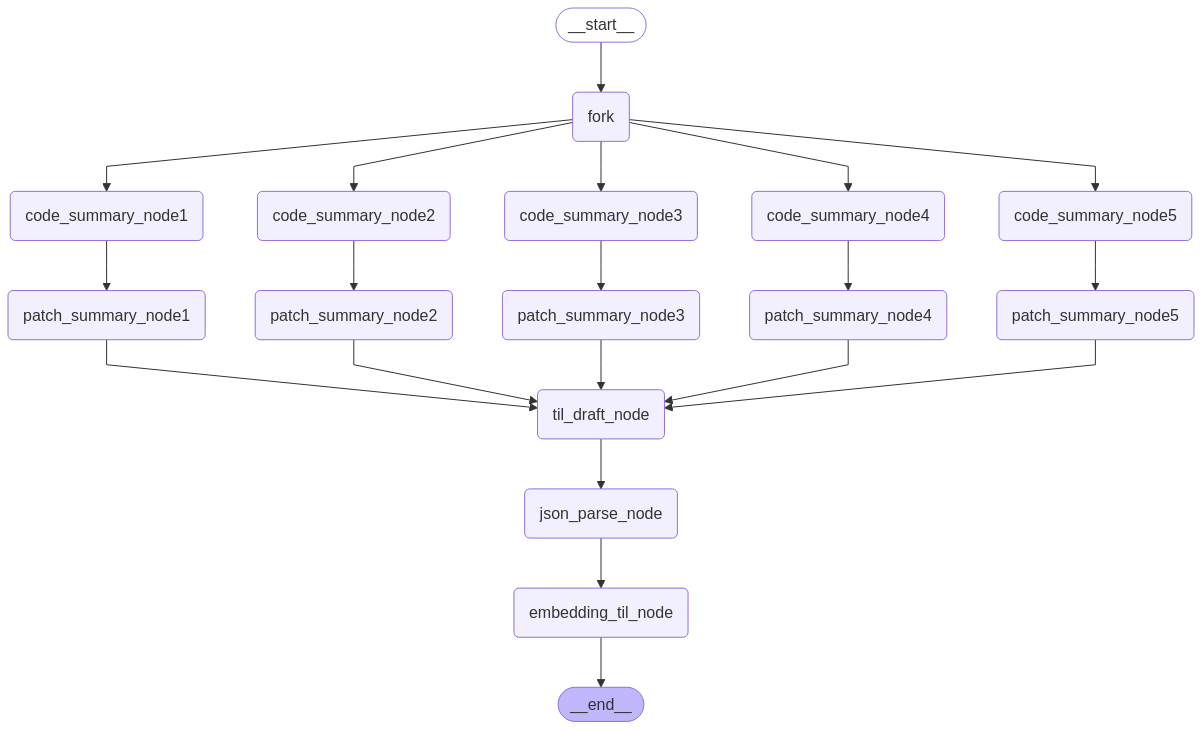

In [137]:
graph

In [139]:
result = await graph.ainvoke(s2)

INFO 05-04 16:54:00 [async_llm.py:228] Added request 55f2613f-5e9a-452a-a0d9-58b88956011d.
INFO 05-04 16:54:00 [async_llm.py:228] Added request f7dff3bd-9a3f-4441-adc9-e8dedf260146.
INFO 05-04 16:54:00 [async_llm.py:228] Added request acc87954-06cb-42c4-8a31-8323091e2e26.
INFO 05-04 16:54:00 [async_llm.py:228] Added request 39136f01-6f9c-4475-9422-1fce77c61b93.
INFO 05-04 16:54:00 [async_llm.py:228] Added request 8bd6bed4-32a9-4647-89bc-f4f3fedd3277.


INFO 05-04 16:54:11 [async_llm.py:228] Added request 9d8e899b-9cc8-45c6-826b-21189989d6a7.
INFO 05-04 16:54:11 [async_llm.py:228] Added request 5e2ad73d-b438-4f14-bf11-949393fc51e1.
INFO 05-04 16:54:11 [async_llm.py:228] Added request 20150ced-4599-45a6-9312-5ef2ac48e8ba.
INFO 05-04 16:54:11 [async_llm.py:228] Added request ab4761c5-76c7-4234-939f-13830aacf58e.
INFO 05-04 16:54:11 [async_llm.py:228] Added request 6868b081-fd82-425f-89d9-c0464331fc9c.
INFO 05-04 16:54:15 [async_llm.py:228] Added request 34e239b0-6c3a-4887-b53e-4b2e1fe18b00.


In [25]:
pprint(result["til_draft"])

('```json\n'
 '{\n'
 '  "user": "ConconDev",\n'
 '  "date": "2024-09-06",\n'
 '  "repo": "backend",\n'
 '  "title": "ÏïåÎûå Íµ¨ÎèÖ ÏÑúÎπÑÏä§ Î∞è SSE Ïä§Ìä∏Î¶¨Î∞ç Íµ¨ÌòÑ",\n'
 '  "keywords": ["ÏïåÎûå Íµ¨ÎèÖ", "SSE", "Authorization", "SseEmitter"],\n'
 '  "content": "# ÏïåÎûå Íµ¨ÎèÖ ÏÑúÎπÑÏä§ Î∞è SSE Ïä§Ìä∏Î¶¨Î∞ç Íµ¨ÌòÑ\\n\\nÏò§Îäò ÏïåÎûå Íµ¨ÎèÖ ÏÑúÎπÑÏä§Î•º Ï†úÍ≥µÌïòÎäî Ïª®Ìä∏Î°§Îü¨Î•º Í∞úÎ∞úÌïòÍ≥†, '
 'ÏÑúÎ≤ÑÏóêÏÑú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î°ú Ïã§ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏÜ°ÌïòÍ∏∞ ÏúÑÌïú SSE(Server-Sent Events) Ïä§Ìä∏Î¶¨Î∞ç Í∏∞Îä•ÏùÑ '
 'Íµ¨ÌòÑÌñàÏäµÎãàÎã§.\\n\\n## 1. Ïò§Îäò Î∞∞Ïö¥ ÎÇ¥Ïö©\\n\\n*   **SSE:** ÏÑúÎ≤ÑÏóêÏÑú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î°ú Îã®Î∞©Ìñ• Ïã§ÏãúÍ∞Ñ ÌÜµÏã†ÏùÑ Ï†úÍ≥µÌïòÎäî Ïõπ '
 'Í∏∞Ïà†ÏûÖÎãàÎã§. HTTP Ïó∞Í≤∞ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÏÑúÎ≤ÑÍ∞Ä ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Î•º Î≥¥ÎÇ¥Îäî Î∞©ÏãùÏûÖÎãàÎã§.\\n*   **SseEmitter:** SSE Ïä§Ìä∏Î¶ºÏùÑ '
 'Í¥ÄÎ¶¨ÌïòÎäî ÌÅ¥ÎûòÏä§Î°ú, Ïó∞Í≤∞ Í¥ÄÎ¶¨, Î©îÏãúÏßÄ Ï†ÑÏÜ° Îì±ÏùÑ Îã¥ÎãπÌï©ÎãàÎã§.\\n*   **Authorization Ìó§Îçî:** ÏöîÏ≤≠Ïóê ÎåÄÌïú Ïù∏Ï¶ù Ï†ïÎ≥¥Î•º '
 'Îã¥Í≥† ÏûàÎ

In [26]:
result["til_json"]

{'user': 'ConconDev',
 'date': '2024-09-06',
 'repo': 'backend',
 'title': 'ÏïåÎûå Íµ¨ÎèÖ ÏÑúÎπÑÏä§ Î∞è SSE Ïä§Ìä∏Î¶¨Î∞ç Íµ¨ÌòÑ',
 'keywords': ['ÏïåÎûå Íµ¨ÎèÖ', 'SSE', 'Authorization', 'SseEmitter'],
 'content': '# ÏïåÎûå Íµ¨ÎèÖ ÏÑúÎπÑÏä§ Î∞è SSE Ïä§Ìä∏Î¶¨Î∞ç Íµ¨ÌòÑ\n\nÏò§Îäò ÏïåÎûå Íµ¨ÎèÖ ÏÑúÎπÑÏä§Î•º Ï†úÍ≥µÌïòÎäî Ïª®Ìä∏Î°§Îü¨Î•º Í∞úÎ∞úÌïòÍ≥†, ÏÑúÎ≤ÑÏóêÏÑú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î°ú Ïã§ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏÜ°ÌïòÍ∏∞ ÏúÑÌïú SSE(Server-Sent Events) Ïä§Ìä∏Î¶¨Î∞ç Í∏∞Îä•ÏùÑ Íµ¨ÌòÑÌñàÏäµÎãàÎã§.\n\n## 1. Ïò§Îäò Î∞∞Ïö¥ ÎÇ¥Ïö©\n\n*   **SSE:** ÏÑúÎ≤ÑÏóêÏÑú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î°ú Îã®Î∞©Ìñ• Ïã§ÏãúÍ∞Ñ ÌÜµÏã†ÏùÑ Ï†úÍ≥µÌïòÎäî Ïõπ Í∏∞Ïà†ÏûÖÎãàÎã§. HTTP Ïó∞Í≤∞ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÏÑúÎ≤ÑÍ∞Ä ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Î•º Î≥¥ÎÇ¥Îäî Î∞©ÏãùÏûÖÎãàÎã§.\n*   **SseEmitter:** SSE Ïä§Ìä∏Î¶ºÏùÑ Í¥ÄÎ¶¨ÌïòÎäî ÌÅ¥ÎûòÏä§Î°ú, Ïó∞Í≤∞ Í¥ÄÎ¶¨, Î©îÏãúÏßÄ Ï†ÑÏÜ° Îì±ÏùÑ Îã¥ÎãπÌï©ÎãàÎã§.\n*   **Authorization Ìó§Îçî:** ÏöîÏ≤≠Ïóê ÎåÄÌïú Ïù∏Ï¶ù Ï†ïÎ≥¥Î•º Îã¥Í≥† ÏûàÎäî Ìó§ÎçîÏûÖÎãàÎã§. JWT(JSON Web Token)Î•º ÏÇ¨Ïö©ÌïòÏó¨ Ïù∏Ï¶ùÌïòÎäî Í≤ΩÏö∞, Auth

: 

In [56]:
# 3. TIL Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
til_json = result["til_json"]

# 4. Î≤°ÌÑ∞ ÏûÑÎ≤†Îî© ÏÉùÏÑ± (title + content)
text = f"query: {til_json['title']} \n {til_json['content']}"
encoded = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    output = model(**encoded)
    vector = output.last_hidden_state.mean(dim=1)[0].tolist()

# 5. Î≤°ÌÑ∞Î•º Ï†úÏô∏Ìïú payload Íµ¨ÏÑ±
payload = {k: v for k, v in til_json.items() if k != "vector"}

print(payload)
print(vector)

# 6. Qdrant Point ÏÉùÏÑ± Î∞è Ï†ÄÏû•
point = PointStruct(
    id=str(uuid.uuid4()),
    vector=vector,
    payload=payload
)

client.upsert(collection_name="til_logs", points=[point])

{'user': 'ConconDev', 'date': '2024-09-06', 'repo': 'backend', 'title': 'Ïã§ÏãúÍ∞Ñ ÏïåÎûå Íµ¨ÎèÖ Í∏∞Îä• Íµ¨ÌòÑ: SSE & AlarmService Ïó∞Îèô', 'keywords': ['SSE', 'Server-Sent Events', 'ÏïåÎûå', 'Ïã§ÏãúÍ∞Ñ', 'AlarmService'], 'content': '# Ïã§ÏãúÍ∞Ñ ÏïåÎûå Íµ¨ÎèÖ Í∏∞Îä• Íµ¨ÌòÑ: SSE & AlarmService Ïó∞Îèô\n\nÏò§Îäò Ï†ÄÎäî Ïã§ÏãúÍ∞Ñ ÏïåÎûå Íµ¨ÎèÖ Í∏∞Îä•ÏùÑ Íµ¨ÌòÑÌïòÍ∏∞ ÏúÑÌï¥ SSE (Server-Sent Events)Î•º ÎèÑÏûÖÌïòÍ≥†, Í∏∞Ï°¥Ïùò AlarmServiceÏôÄ Ïó∞ÎèôÌñàÏäµÎãàÎã§.\n\n## 1. Ïò§Îäò Î∞∞Ïö¥ ÎÇ¥Ïö©\n\n*   **SSE (Server-Sent Events):** ÏÑúÎ≤ÑÏóêÏÑú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏Î°ú Îã®Î∞©Ìñ• Ïã§ÏãúÍ∞Ñ ÌÜµÏã†ÏùÑ Í∞ÄÎä•ÌïòÍ≤å ÌïòÎäî Í∏∞Ïà†ÏûÖÎãàÎã§. ÏÑúÎ≤ÑÍ∞Ä ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÎ©¥ ÏûêÎèôÏúºÎ°ú ÌÅ¥ÎùºÏù¥Ïñ∏Ìä∏ÏóêÍ≤å Ï†ÑÎã¨Ìï©ÎãàÎã§.\n*   **SseEmitter:** SSEÎ•º ÏâΩÍ≤å Íµ¨ÌòÑÌï† Ïàò ÏûàÎèÑÎ°ù ÎèÑÏôÄÏ£ºÎäî ÌÅ¥ÎûòÏä§ÏûÖÎãàÎã§. Ïó∞Í≤∞ Í¥ÄÎ¶¨, Î©îÏãúÏßÄ Ï†ÑÏÜ° Îì±ÏùÑ Ìé∏Î¶¨ÌïòÍ≤å Ï≤òÎ¶¨Ìï¥Ï§çÎãàÎã§.\n*   **AlarmService:** ÏïåÎûå Í¥ÄÎ†® Î°úÏßÅÏùÑ Îã¥ÎãπÌïòÎäî ÏÑúÎπÑÏä§ÏûÖÎãàÎã§. ÏïåÎûå Íµ¨ÎèÖ, Ìï¥Ï†ú, ÏÉÅÌÉú Î≥

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [61]:
import json

til_json = result["til_json"]

# ÌååÏùºÎ°ú Ï†ÄÏû•
with open("til_result.json", "w", encoding="utf-8") as f:
    json.dump(til_json, f, ensure_ascii=False, indent=2)